In [1]:
# Kernel 1: Load Data and Calculate Technical Indicators
import yfinance as yf
import talib
import pandas as pd
import numpy as np

# Define stocks and timeframes
stocks = ['COST', 'UL', 'AMGN', 'UNH', 'WAT', 'UPS', 'LPX', 'WM', 'NVDA',
    'GOOGL', 'MSFT', 'AXP', 'BLK', 'BRK-B', 'NEE', 'XOM', 'CNI']
timeframes = [20, 50, 100, 200]  # Short, medium, and long-term
start_date = '2010-01-01'
end_date = '2024-01-01'

# Initialize a DataFrame to store combined data
all_data = []

for stock in stocks:
    print(f"Processing {stock}...")
    data = yf.download(stock, start=start_date, end=end_date)

    if data.empty or 'Close' not in data:
        print(f"No data available for {stock}. Skipping...")
        continue

    # Add technical indicators for each timeframe
    for tf in timeframes:
        data[f'SMA_{tf}'] = talib.SMA(data['Close'], timeperiod=tf)
        upper_band, middle_band, lower_band = talib.BBANDS(
            data['Close'], timeperiod=tf, nbdevup=2, nbdevdn=2, matype=0
        )
        data[f'BB_Upper_{tf}'] = upper_band
        data[f'BB_Middle_{tf}'] = middle_band
        data[f'BB_Lower_{tf}'] = lower_band
        data[f'Volatility_{tf}'] = data['Close'].pct_change().rolling(tf).std()

    # Calculate 6-month forward return
    data['Cumulative_Return'] = data['Close'].shift(-126) / data['Close'] - 1

    # Append to all_data
    data['Stock'] = stock
    all_data.append(data)

# Combine all stock data
final_data = pd.concat(all_data)
final_data.dropna(inplace=True)  # Drop rows with missing values
final_data.to_csv('processed_technical_indicators.csv', index=False)
print("Processed data saved to 'processed_technical_indicators.csv'.")

Processing COST...
[*********************100%%**********************]  1 of 1 completed
Processing UL...
[*********************100%%**********************]  1 of 1 completed
Processing AMGN...
[*********************100%%**********************]  1 of 1 completed
Processing UNH...
[*********************100%%**********************]  1 of 1 completed
Processing WAT...
[*********************100%%**********************]  1 of 1 completed
Processing UPS...
[*********************100%%**********************]  1 of 1 completed
Processing LPX...
[*********************100%%**********************]  1 of 1 completed
Processing WM...
[*********************100%%**********************]  1 of 1 completed
Processing NVDA...
[*********************100%%**********************]  1 of 1 completed
Processing GOOGL...
[*********************100%%**********************]  1 of 1 completed
Processing MSFT...
[*********************100%%**********************]  1 of 1 completed
Processing AXP...
[********************

In [2]:
# Kernel 2: Correlation Analysis
import pandas as pd

# Load processed data
data = pd.read_csv('processed_technical_indicators.csv')

# Initialize correlation results
timeframes = [20, 50, 100, 200]
correlations = []

for tf in timeframes:
    for feature in [f'SMA_{tf}', f'BB_Upper_{tf}', f'BB_Middle_{tf}', f'BB_Lower_{tf}', f'Volatility_{tf}']:
        corr = data[['Cumulative_Return', feature]].corr().iloc[0, 1]
        correlations.append({'Feature': feature, 'Timeframe': tf, 'Correlation': corr})

# Convert to DataFrame and save results
correlation_df = pd.DataFrame(correlations)
correlation_df.to_csv('correlation_results.csv', index=False)
print("Correlation analysis completed. Results saved to 'correlation_results.csv'.")

Correlation analysis completed. Results saved to 'correlation_results.csv'.


In [3]:
# Kernel 3: Feature Selection
import pandas as pd

# Load correlation results
correlation_df = pd.read_csv('correlation_results.csv')

# Select top features for each timeframe (threshold: absolute correlation > 0.1)
selected_features = correlation_df[correlation_df['Correlation'].abs() > 0.1]
print("Selected Features:")
print(selected_features)

# Save selected features
selected_features.to_csv('selected_features.csv', index=False)
print("Selected features saved to 'selected_features.csv'.")

Selected Features:
           Feature  Timeframe  Correlation
0           SMA_20         20    -0.119761
1      BB_Upper_20         20    -0.117223
2     BB_Middle_20         20    -0.119761
3      BB_Lower_20         20    -0.122389
4    Volatility_20         20     0.238642
5           SMA_50         50    -0.117578
6      BB_Upper_50         50    -0.113863
7     BB_Middle_50         50    -0.117578
8      BB_Lower_50         50    -0.121596
9    Volatility_50         50     0.260414
10         SMA_100        100    -0.117214
11    BB_Upper_100        100    -0.111587
12   BB_Middle_100        100    -0.117214
13    BB_Lower_100        100    -0.123798
14  Volatility_100        100     0.275575
15         SMA_200        200    -0.115149
16    BB_Upper_200        200    -0.107983
17   BB_Middle_200        200    -0.115149
18    BB_Lower_200        200    -0.124243
19  Volatility_200        200     0.318477
Selected features saved to 'selected_features.csv'.


In [4]:
# Kernel 4: Model Comparison
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load processed data and selected features
data = pd.read_csv('processed_technical_indicators.csv')
selected_features = pd.read_csv('selected_features.csv')['Feature'].unique()

# Filter data with selected features
X = data[selected_features]
y = data['Cumulative_Return']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
predictions = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Model RMSE: {rmse:.4f}")

Model RMSE: 0.0283


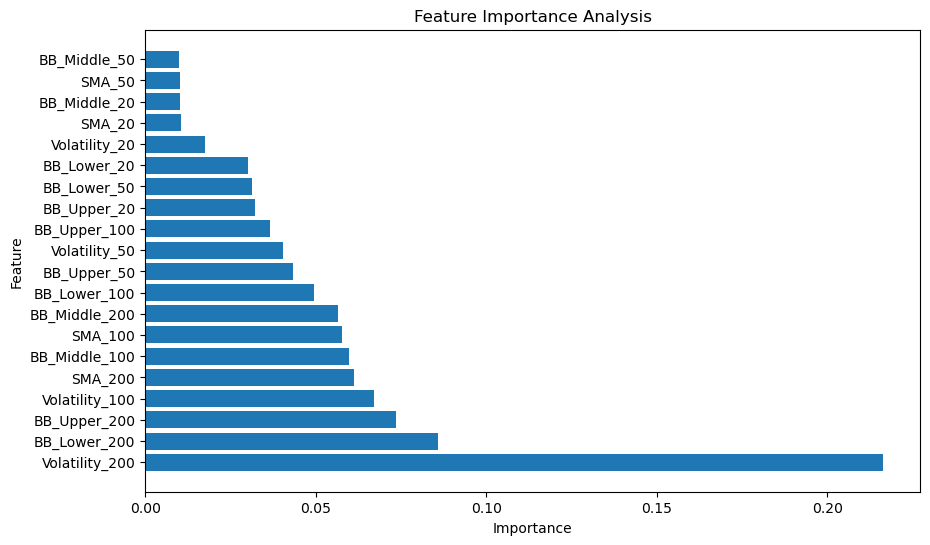

In [5]:
# Kernel 5: Feature Importance Analysis
import matplotlib.pyplot as plt
import os


# Get feature importance from the trained model
importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
downloads_path = os.path.expanduser("~/Downloads")
file_path = os.path.join(downloads_path, "feature_importance_analysis.png")
plt.savefig(file_path, bbox_inches='tight')
plt.show()
